In [1]:
import os
import glob
import duckdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('train_set.csv')
# df.head()

In [3]:
# df.describe().T

In [ ]:
# df.info()

In [5]:
print('No churn', round(df['churn'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Churn', round(df['churn'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('toplam müşteri sayısı :' ,df.shape[0])

No churn 98.66 % of the dataset
Churn 1.34 % of the dataset
toplam müşteri sayısı : 9000000


Modelle alakası olmayan istatistiksel hesaplamalar tüm df e uygulanabilir , feature eng. adımları tüm df e uygulanmalıdır

Öncelikle kaç uygulama kullandığını yazıyorum : 

In [6]:
# Boş listeyi gerçekten boş hale getirelim (string olarak görünüyor)
df["apps"] = df["apps"].apply(lambda x: x if x != "[]" else "")

# Virgülle ayırıp kaç eleman olduğunu sayalım
df["app_count"] = df["apps"].apply(lambda x: len(x.split(",")) if x else 0)

# # Sonucu kontrol edelim
# df[["apps", "app_count"]].head(10)

In [7]:
# Eksik değer sayısını ve yüzdesini hesaplayalım
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Sadece eksik değeri olan sütunları gösterelim
missing_df = pd.DataFrame({"Eksik Değer Sayısı": missing_values, "Eksik Yüzde (%)": missing_percentage})
missing_df = missing_df[missing_df["Eksik Değer Sayısı"] > 0].sort_values(by="Eksik Yüzde (%)", ascending=False)

# Sonucu yazdıralım
print(missing_df)


                   Eksik Değer Sayısı  Eksik Yüzde (%)
avg_call_duration             3297598           36.640
auto_payment                  3010706           33.452
roaming_usage                 2997775           33.309
call_drops                    2997775           33.309
data_usage                     449655            4.996
monthly_charge                 225162            2.502
tenure                          22279            0.248


In [8]:
# import missingno as msno
# import matplotlib.pyplot as plt

# # Eksik değerlerin sütun bazında yoğunluğunu gösteren matris
# plt.figure(figsize=(12, 6))
# msno.matrix(df, fontsize=12)
# plt.title("Eksik Değer Matrisi", fontsize=14)
# plt.show()

# Handling Missing Data

In [9]:

# **1️⃣ roaming_usage → Eğer eksikse, hiç kullanmamıştır (0 ile doldur)**
df['roaming_usage'] = df['roaming_usage'].fillna(0)

# **2️⃣ auto_payment → Eksikler -1 ile doldurulmalı ve int'e çevrilmeli**  ## Bilgi yok anlamında.
df['auto_payment'] = df['auto_payment'].fillna(-1).astype(int)

# **3️⃣ avg_call_duration → Eğer fatura bilgisi (monthly_charge) eksikse veya 0'sa, hiç konuşma yapmamıştır (0 ile doldur)**


df.loc[
    ((df['avg_call_duration'].isnull()) | (df['avg_call_duration'] == 0)) &
    ((df['data_usage'].isnull()) | (df['data_usage'] == 0)) &
    (df['monthly_charge'].isnull()), 
    'monthly_charge'
] = 0

df['avg_call_duration'] = df['avg_call_duration'].fillna(-1)  # Kalan eksikleri -1 yapalım

# **4️⃣ call_drops → Eğer service_type "Broadband" ise 0 ile doldur, kalanları medyan ile doldur**
df.loc[df['service_type'] == "Broadband", 'call_drops'] = 0
df['call_drops'] = df['call_drops'].fillna(df['call_drops'].median())


# **5️⃣ monthly_charge → Yaş (age) ve avg_top_up_count'e göre doldur (Sadece NaN olanları değiştir)**
df['monthly_charge'] = df['monthly_charge'].where(df['monthly_charge'].notnull(),
    df.groupby(['age', 'avg_top_up_count'])['monthly_charge'].transform('mean'))

# **6️⃣ data_usage → Eksik kayıtları silebiliriz çünkü oran düşük**
df = df.dropna(subset=['data_usage'])

# **7️⃣ tenure → Yaş bazlı gruplara göre dolduralım (Sadece NaN olanları değiştir)**
df['tenure'] = df['tenure'].where(df['tenure'].notnull(),
    df.groupby('age')['tenure'].transform('median'))


In [10]:
df.isnull().sum()

id                        0
age                       0
tenure                    0
service_type              0
avg_call_duration         0
data_usage                0
roaming_usage             0
monthly_charge            3
overdue_payments          0
auto_payment              0
avg_top_up_count          0
call_drops                0
customer_support_calls    0
satisfaction_score        0
apps                      0
churn                     0
app_count                 0
dtype: int64

Son defa eksik değer kaldı mı diye kontrol et hala eksik değer varsa sil gitsin !

In [11]:
df = df.dropna(subset=['monthly_charge'])

## Features


Müşteri ne kadar sık çağrı merkezini arıyorsa ve memnuniyeti düşükse, bu müşterinin sorun yaşama veya hizmetten memnun kalmama ihtimali artar : support_call_impact
# Bunda aykırı değer olabilir dikkat etmek lazım !!!

In [13]:
import pandas as pd

# 1️⃣ Memnuniyet Skorunu Kategorik Hale Getirme
df["satisfaction_category"] = pd.cut(df["satisfaction_score"], bins=[0, 4, 7, 10], labels=["Düşük", "Orta", "Yüksek"])

# 2️⃣ Destek Çağrılarının Memnuniyete Etkisi --> çağrı sayısı arttıkça ve satisfaction_score düştükçe 
df["support_call_impact"] = df["customer_support_calls"] / (df["satisfaction_score"] + 1)

# 3️⃣ Aylık Fatura Kategorisi
df["billing_category"] = pd.cut(df["monthly_charge"], bins=[0, 250, 500, 1000, 2500], 
                                labels=["Düşük", "Orta", "Yüksek", "Premium"])

# 4️⃣ Memnuniyetsizlik Skoru (Yüksek Fatura, Düşük Kullanım)
df["dissatisfaction_score"] = df["monthly_charge"] / (df["data_usage"] + df["avg_call_duration"] + 1)

# 5️⃣ Finansal Risk Skoru
df["financial_risk_score"] = df["monthly_charge"] * df["overdue_payments"] / (df["avg_top_up_count"] + 1)

# 6️⃣ Yaş Segmenti
df["age_group"] = pd.cut(df["age"], bins=[16, 25, 35, 50, 85], labels=["Genç", "Orta", "Yetişkin", "Yaşlı"])

# 7️⃣ Roaming Kullanım Segmenti
df["roaming_usage_category"] = pd.cut(df["roaming_usage"], bins=[-1, 0, 10, 50, 1000], 
                                      labels=["Hiç Kullanmadı", "Ara Sıra", "Sık Kullanıcı", "Çok Sık Kullanıcı"])

# 8️⃣ Sadakat Skoru
df["loyalty_score"] = df["tenure"] * df["avg_top_up_count"] / (df["customer_support_calls"] + 1)

# 9️⃣ Fatura Ağırlığı
df["billing_weight"] = df["monthly_charge"] / (df["age"] + 1)


## Encoding


In [14]:
num_but_cat = [col for col in df.columns if  df[col].nunique() < 35  and df[col].dtype in ["float64" ,"int64"]]

num_cols = [col for col in df.columns if df[col].dtype in ["float64" ,"int64"] and col not in num_but_cat]

cat_cols = [col for col in df.columns if df[col].dtype in ["object" , "category"]]
cat_but_car = [col for col in cat_cols if df[col].nunique() > 35]


print(f" \n Numeric cols : {num_cols} \n")
print(f" \n Numeric but actually categoric cols : {num_but_cat} \n")
print(f" \n Categorical Cols : {cat_cols} \n")
print(f" \n Categorical but high cardinality cols : {cat_but_car} \n")

 
 Numeric cols : ['age', 'tenure', 'avg_call_duration', 'data_usage', 'roaming_usage', 'monthly_charge', 'avg_top_up_count', 'satisfaction_score', 'support_call_impact', 'dissatisfaction_score', 'financial_risk_score', 'loyalty_score', 'billing_weight'] 

 
 Numeric but actually categoric cols : ['overdue_payments', 'call_drops', 'customer_support_calls', 'app_count'] 

 
 Categorical Cols : ['id', 'service_type', 'apps', 'satisfaction_category', 'billing_category', 'age_group', 'roaming_usage_category'] 

 
 Categorical but high cardinality cols : ['id'] 



# Train-Test Ayrımı
En baştan yapıyorum sonradan karışıklık olamsın.

In [15]:
from sklearn.model_selection import train_test_split

# Train/test split (stratify: churn dağılımını korumak için)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["churn"], random_state=42)

## UnderSampling

In [16]:
def manual_undersampling(X, y):
    # 1️⃣ DataFrame'e çevir
    df = X.copy()
    df["churn"] = y  # Hedef değişkeni tekrar ekleyelim

    # 2️⃣ Churn etmeyen (0) ve eden (1) müşterileri ayıralım
    churn_0 = df[df["churn"] == 0]  # Churn etmeyenler
    churn_1 = df[df["churn"] == 1]  # Churn edenler

    # 3️⃣ Minimum sınıfın (churn=1) boyutunu öğrenelim
    min_class_size = len(churn_1)

    # 4️⃣ Churn etmeyenlerden rastgele örnek alalım (churn edenlerle eşit sayıda)
    churn_0_sample = churn_0.sample(n=min_class_size, random_state=42)

    # 5️⃣ İki grubu birleştirelim
    balanced_df = pd.concat([churn_0_sample, churn_1], axis=0)

    # 6️⃣ Karıştıralım
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # 7️⃣ X ve y olarak ayıralım
    X_balanced = balanced_df.drop(columns=["churn"])
    y_balanced = balanced_df["churn"]

    return X_balanced, y_balanced


In [17]:
X = df.drop(columns=["churn"])
y = df["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2️⃣ Manuel undersampling uygulayalım
X_train_resampled, y_train_resampled = manual_undersampling(X_train, y_train)

# 3️⃣ Sonucu kontrol edelim
print("Orijinal veri setindeki sınıf dağılımı:")
print(y_train.value_counts())

print("\nUndersampling sonrası veri setindeki sınıf dağılımı:")
print(y_train_resampled.value_counts())

Orijinal veri setindeki sınıf dağılımı:
churn
False    6748865
True       91408
Name: count, dtype: int64

Undersampling sonrası veri setindeki sınıf dağılımı:
churn
True     91408
False    91408
Name: count, dtype: int64


## Encoding

In [18]:
# 1️⃣ Manuel Label Encoding - Önce mapping tanımlayalım
service_type_map = {"Prepaid": 0, "Broadband": 1, "Postpaid": 2}
billing_category_map = {"Düşük": 0, "Orta": 1, "Yüksek": 2, "Premium": 3}
age_group_map = {"Yaşlı": 0, "Orta": 1, "Yetişkin": 2, "Genç": 3}
roaming_usage_map = {"Hiç Kullanmadı": 0, "Ara Sıra": 1, "Sık Kullanıcı": 2, "Çok Sık Kullanıcı": 3}

# 2️⃣ Mapping uygulayalım
X_train_resampled["service_type"] = X_train_resampled["service_type"].map(service_type_map)
X_test["service_type"] = X_test["service_type"].map(service_type_map)

X_train_resampled["billing_category"] = X_train_resampled["billing_category"].map(billing_category_map)
X_test["billing_category"] = X_test["billing_category"].map(billing_category_map)

X_train_resampled["age_group"] = X_train_resampled["age_group"].map(age_group_map)
X_test["age_group"] = X_test["age_group"].map(age_group_map)

X_train_resampled["roaming_usage_category"] = X_train_resampled["roaming_usage_category"].map(roaming_usage_map)
X_test["roaming_usage_category"] = X_test["roaming_usage_category"].map(roaming_usage_map)

# 3️⃣ Satisfaction Category için Label Encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X_train_resampled["satisfaction_category"] = le.fit_transform(X_train_resampled["satisfaction_category"])
X_test["satisfaction_category"] = le.transform(X_test["satisfaction_category"])

In [19]:
print(X_train_resampled[["service_type", "billing_category", "age_group", "roaming_usage_category"]].isnull().sum())
print(X_test[["service_type", "billing_category", "age_group", "roaming_usage_category"]].isnull().sum())

service_type              0
billing_category          0
age_group                 0
roaming_usage_category    0
dtype: int64
service_type              0
billing_category          0
age_group                 0
roaming_usage_category    0
dtype: int64


In [20]:
X_train_resampled = X_train_resampled.drop(columns=["id", "apps"])
X_test = X_test.drop(columns=["id", "apps"])

In [22]:
print(X_train_resampled.head())
print(X_train_resampled.dtypes)

   age  tenure  service_type  avg_call_duration  data_usage  roaming_usage  monthly_charge  overdue_payments  auto_payment  avg_top_up_count  call_drops  customer_support_calls  satisfaction_score  app_count  satisfaction_category  support_call_impact billing_category  dissatisfaction_score  financial_risk_score age_group roaming_usage_category  loyalty_score  billing_weight
0   55 320.000             2             23.050      11.100         18.620         829.390                 5             0                 0       2.000                      12               7.840          0                      2                1.357                2                 23.596              4146.950         0                      2          0.000          14.811
1   32 113.000             2             31.760     170.070         16.570         590.130                 4             1                 0       9.000                      18               4.040          1                      1              

In [24]:
# Hâlâ kategori olarak kalan sütunları belirleyelim
category_cols = ["billing_category", "roaming_usage_category", "age_group"]

# Bu sütunları integer formata çevirelim
for col in category_cols:
    X_train_resampled[col] = X_train_resampled[col].astype(int)
    X_test[col] = X_test[col].astype(int)

# Sonuçları kontrol edelim
print(X_train_resampled.dtypes)

age                         int64
tenure                    float64
service_type                int64
avg_call_duration         float64
data_usage                float64
roaming_usage             float64
monthly_charge            float64
overdue_payments            int64
auto_payment                int32
avg_top_up_count            int64
call_drops                float64
customer_support_calls      int64
satisfaction_score        float64
app_count                   int64
satisfaction_category       int32
support_call_impact       float64
billing_category            int32
dissatisfaction_score     float64
financial_risk_score      float64
age_group                   int32
roaming_usage_category      int32
loyalty_score             float64
billing_weight            float64
dtype: object


# Model Aşaması 

Scaling atladım çünkü direkt LightGBM veya XGBoost kullanacağım.

In [25]:
print("Train Set Şekli:", X_train_resampled.shape)
print("Test Set Şekli:", X_test.shape)

print("\nVeri Türleri:")
print(X_train_resampled.dtypes.value_counts())  # Tüm sütunlar float64 veya int64 olmalı

print("\nİlk Satır:")
print(X_train_resampled.head())


Train Set Şekli: (182816, 23)
Test Set Şekli: (1710069, 23)

Veri Türleri:
float64    12
int64       6
int32       5
Name: count, dtype: int64

İlk Satır:
   age  tenure  service_type  avg_call_duration  data_usage  roaming_usage  monthly_charge  overdue_payments  auto_payment  avg_top_up_count  call_drops  customer_support_calls  satisfaction_score  app_count  satisfaction_category  support_call_impact  billing_category  dissatisfaction_score  financial_risk_score  age_group  roaming_usage_category  loyalty_score  billing_weight
0   55 320.000             2             23.050      11.100         18.620         829.390                 5             0                 0       2.000                      12               7.840          0                      2                1.357                 2                 23.596              4146.950          0                       2          0.000          14.811
1   32 113.000             2             31.760     170.070         16.570         

### XGBoost

In [26]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# 1️⃣ XGBoost modelini oluştur
xgb_model = XGBClassifier(
    objective="binary:logistic",  
    eval_metric="auc",  # AUC metriğini optimize edelim
    use_label_encoder=False,  # Uyarı mesajlarını önlemek için
    random_state=42
)

# 2️⃣ Modeli eğit
xgb_model.fit(X_train_resampled, y_train_resampled)

# 3️⃣ Test setinde tahmin yap
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# 4️⃣ Modelin performansını değerlendirme
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Accuracy Score:", accuracy_score(y_test, y_pred))




Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.66      0.79   1687217
        True       0.03      0.82      0.06     22852

    accuracy                           0.66   1710069
   macro avg       0.51      0.74      0.43   1710069
weighted avg       0.98      0.66      0.78   1710069


ROC AUC Score: 0.796865952455439
Accuracy Score: 0.6612481718573929


# Özellik Önem Derecesi

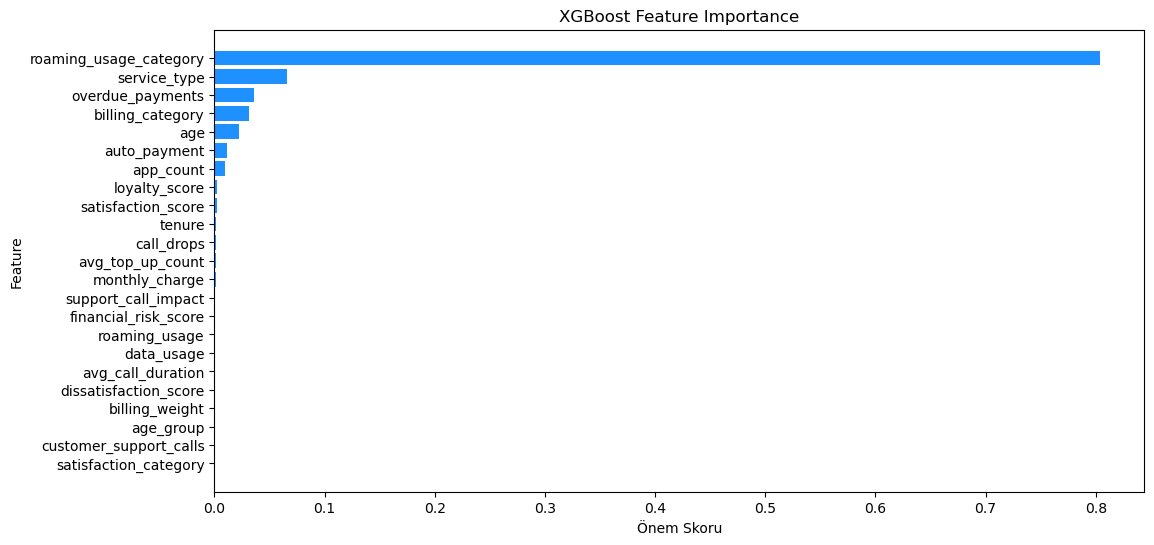

                   Feature  Importance
20  roaming_usage_category       0.804
2             service_type       0.066
7         overdue_payments       0.036
16        billing_category       0.031
0                      age       0.022
8             auto_payment       0.012
13               app_count       0.010
21           loyalty_score       0.003
12      satisfaction_score       0.002
1                   tenure       0.001


In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Feature Importance'ı al
feature_importances = xgb_model.feature_importances_
feature_names = X_train_resampled.columns

# DataFrame oluştur
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Görselleştirme
plt.figure(figsize=(12, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="dodgerblue")
plt.xlabel("Önem Skoru")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# İlk 10 değişkeni yazdır
print(importance_df.head(10))


# LightGBM

In [28]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# LightGBM Modelini oluştur
lgbm_model = LGBMClassifier(
    objective="binary",
    metric="auc",
    random_state=42
)

# Modeli eğit
lgbm_model.fit(X_train_resampled, y_train_resampled)

# Test setinde tahmin yap
y_pred_lgbm = lgbm_model.predict(X_test)
y_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

# Model performansını değerlendirme
print("\nClassification Report (LightGBM):")
print(classification_report(y_test, y_pred_lgbm))

print("\nROC AUC Score (LightGBM):", roc_auc_score(y_test, y_proba_lgbm))
print("Accuracy Score (LightGBM):", accuracy_score(y_test, y_pred_lgbm))


[LightGBM] [Info] Number of positive: 91408, number of negative: 91408
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3039
[LightGBM] [Info] Number of data points in the train set: 182816, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Classification Report (LightGBM):
              precision    recall  f1-score   support

       False       1.00      0.67      0.80   1687217
        True       0.03      0.82      0.06     22852

    accuracy                           0.67   1710069
   macro avg       0.51      0.74      0.43   1710069
weighted avg       0.98      0.67      0.79   1710069


ROC AUC Score (LightGBM): 0.7997652764861379
Accuracy Score (LightGBM): 0.667987665994764


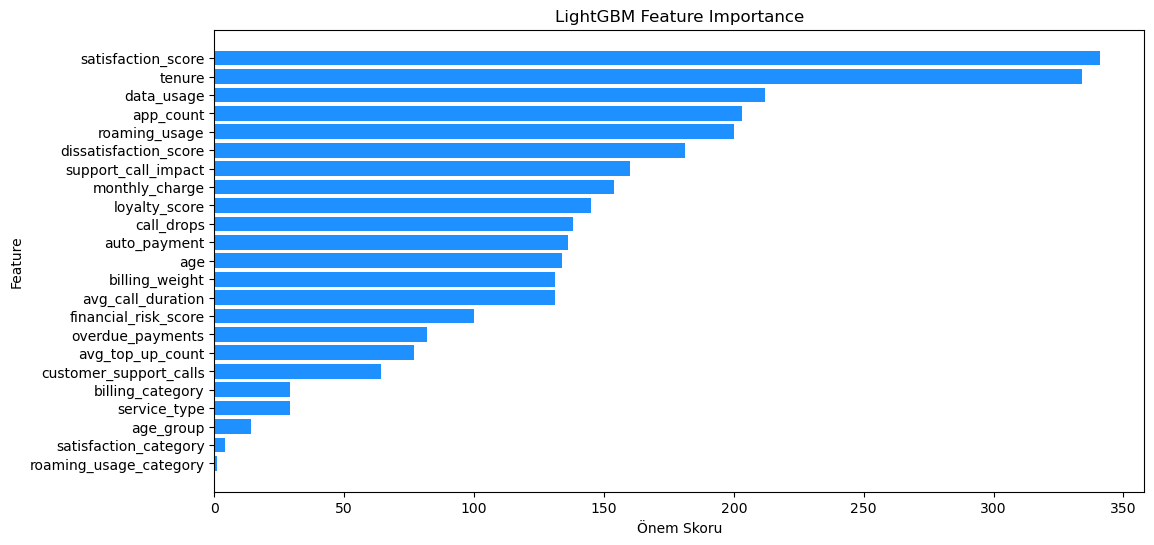

                  Feature  Importance
12     satisfaction_score         341
1                  tenure         334
4              data_usage         212
13              app_count         203
5           roaming_usage         200
17  dissatisfaction_score         181
15    support_call_impact         160
6          monthly_charge         154
21          loyalty_score         145
10             call_drops         138


In [ ]:
# Feature Importance'ı al
feature_importances = lgbm_model.feature_importances_
feature_names = X_train_resampled.columns

# DataFrame oluştur
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Görselleştirme
plt.figure(figsize=(12, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="dodgerblue")
plt.xlabel("Önem Skoru")
plt.ylabel("Feature")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# İlk 10 değişkeni yazdır
print(importance_df.head(10))

In [31]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

# Optuna için hedef fonksiyon
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),  # 1000 yerine 500'e düşürdük
        "max_depth": trial.suggest_int("max_depth", 3, 8),  # Daha dar aralık
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.2, log=True),  # Çok düşük learning rate denemiyoruz
        "num_leaves": trial.suggest_int("num_leaves", 20, 80),  # 150 yerine 80'e düşürdük
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),  # 5-100 yerine 10-50
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),  # Alt sınırı artırdık
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),  # Çok düşük değerleri çıkardık
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 5.0, log=True),  # 10 yerine 5'e düşürdük
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 5.0, log=True),  # 10 yerine 5'e düşürdük
    }
    
    # Modeli eğit
    model = LGBMClassifier(objective="binary", metric="auc", random_state=42, **params, n_jobs=-1)  # Paralel çalıştırma
    model.fit(X_train_resampled, y_train_resampled)
    
    # Tahmin yap
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # AUC skoru döndür
    return roc_auc_score(y_test, y_proba)

# Optuna’yı başlat ve hızlandırılmış şekilde çalıştır
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, n_jobs=-1)  # Daha az deneme, paralel çalıştırma

# En iyi parametreleri yazdır
print("\nEn İyi Parametreler (Hızlandırılmış LightGBM Optuna):")
print(study.best_params)

# Optuna ile en iyi parametreleri kullanarak yeni LightGBM modeli eğitelim
best_params = study.best_params
optimized_lgbm = LGBMClassifier(objective="binary", metric="auc", random_state=42, **best_params, n_jobs=-1)

# Modeli eğit
optimized_lgbm.fit(X_train_resampled, y_train_resampled)

# Tahmin yap
y_pred_opt = optimized_lgbm.predict(X_test)
y_proba_opt = optimized_lgbm.predict_proba(X_test)[:, 1]

# Sonuçları değerlendirme
print("\nOptimized LightGBM Classification Report:")
print(classification_report(y_test, y_pred_opt))

print("\nOptimized LightGBM ROC AUC Score:", roc_auc_score(y_test, y_proba_opt))
print("Optimized LightGBM Accuracy Score:", accuracy_score(y_test, y_pred_opt))

[I 2025-02-08 03:15:33,963] A new study created in memory with name: no-name-d6968683-69f6-4099-8e42-bfe608dc801e
[I 2025-02-08 03:15:38,470] Trial 9 finished with value: 0.7974552205539316 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.06164535642338162, 'num_leaves': 51, 'min_child_samples': 34, 'subsample': 0.7382077742960149, 'colsample_bytree': 0.7082228804167245, 'reg_lambda': 1.8822531168444203, 'reg_alpha': 0.0015201120967626262}. Best is trial 9 with value: 0.7974552205539316.
[I 2025-02-08 03:15:40,691] Trial 8 finished with value: 0.7994323043337489 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.08520788090010041, 'num_leaves': 56, 'min_child_samples': 33, 'subsample': 0.7181255544887879, 'colsample_bytree': 0.8937396083010467, 'reg_lambda': 4.958487952767012, 'reg_alpha': 0.04552413207704035}. Best is trial 8 with value: 0.7994323043337489.
[I 2025-02-08 03:15:46,789] Trial 7 finished with value: 0.799433075673665 and para


En İyi Parametreler (Hızlandırılmış LightGBM Optuna):
{'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.06158936904738249, 'num_leaves': 21, 'min_child_samples': 42, 'subsample': 0.78768477057274, 'colsample_bytree': 0.7660539515108424, 'reg_lambda': 0.0034397469588336735, 'reg_alpha': 3.696667377877249}
[LightGBM] [Info] Number of positive: 91408, number of negative: 91408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3039
[LightGBM] [Info] Number of data points in the train set: 182816, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [32]:
optuna.visualization.plot_param_importances(study)


Bu grafikler, hangi hiperparametrenin modelin performansına ne kadar katkıda bulunduğunu gösterir.

. Optuna Parametre Önem Sıralaması Ne Anlama Geliyor?
Optuna’nın plot_param_importances(study) çıktısı hangi hiperparametrelerin AUC skoruna en çok etki ettiğini gösterir.

Grafikte en üstteki parametre en kritik olanıdır.
En alttaki parametre ise modelin performansını neredeyse hiç değiştirmemiştir.


In [33]:
import joblib  

# Optuna ile en iyi parametreleri bulan modeli kaydedelim
joblib.dump(optimized_lgbm, "optimized_lightgbm.pkl")  

print("✅ LightGBM modeli başarıyla kaydedildi!")


✅ LightGBM modeli başarıyla kaydedildi!


Aşağıda analize devam ediyorum.

In [ ]:
# Churn olasılıklarını alalım
X_test["churn_probability"] = y_proba_opt  # LightGBM’den gelen olasılık skorları

# En riskli müşterileri sıralayalım
top_risky_customers = X_test.sort_values(by="churn_probability", ascending=False).head(500)

# En yüksek churn riski taşıyan müşterileri görüntüleyelim
print(top_risky_customers[["churn_probability", "tenure", "satisfaction_score", "monthly_charge", "roaming_usage"]].head(50))


         churn_probability  tenure  satisfaction_score  monthly_charge  roaming_usage  age_group
4545911              0.915  68.000               2.980         318.890         57.980          2
557640               0.912  21.000               1.010         501.670         58.840          1
7851060              0.909  32.000               1.760         511.700         55.240          1
7887665              0.908  90.000               2.900         469.480         58.050          1
1064167              0.908 307.000               2.510         455.380         18.030          0
390771               0.906 106.000               2.770          93.760         57.870          2
7220958              0.906 313.000               2.710          89.540          6.710          0
1526829              0.906 287.000               1.410          86.960         23.010          3
1359809              0.906 323.000               1.230          99.650         28.010          0
3401067              0.905  49